# Generative Adversarial Networks (GANs)

到目前为止，我们探索的神经网络的所有应用都是**区分模型**，它们接受输入并经过训练以产生标签输出。 他们的范围从图像类别的直接分类到句子生成（这一直被称为分类问题，我们的标签在词汇空间中，并且我们学会了用循环去捕获多词标签）。 在该 notebook 中，我们将扩展功能范围，并使用神经网络构建**生成模型**。 具体来说，我们将学习如何构建模型，以生成一张全新的图片（注意 GAN 无法生成没见过的元素，换句话说 GAN 生成的所谓的全新的图片是训练集图片的某种重组）。

### 什么是 GAN ？

2014年的时候 [Goodfellow et al.](https://arxiv.org/abs/1406.2661) 提出了一种用于训练生成模型的方法，称为生成对抗网络（简称GAN）。在 GAN 里面我们构建了两种神经网络。第一个网络是一个传统的分类网络名为 **判别器（discriminator）** 。我们会训练判别器让它将输入图片分类为两个类别：真实的（属于训练集）或伪造的（不在训练集中）。另一个网络为 **生成器（generator）**，它接受噪声作为输入然后用一个神经网络去将其转换成图片。生成器的目的是使判别器误以为生成器生成的图像是真实的。

我们可以将生成器 ($G$) 试图欺骗判别器 ($D$) 以及判别器试图区分图片为真实还是假冒的这种来回过程视为minimax游戏：

$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

其中 $z \sim p(z)$ 为随机噪声样本， $G(z)$ 为用神经网络生成器 $G$ 生成的图片， $D$ 为判别器的输出结果它能告诉我们输入图片为真实图片的概率。在 [Goodfellow et al.](https://arxiv.org/abs/1406.2661) 中，他们分析了这个minimax游戏，并展示了它是如何最小化训练集的数据分布和 $G$ 生成的样本之间的Jensen-Shannon divergence（JS散度）的。

为了优化此minimax游戏，我们将交替在目标 $G$ 上执行梯度*下降*步骤，并在目标 $D$ 上执行梯度*上升*步骤：
- 1.更新 **生成器** ($G$) 以最小化__判别器做出正确选择__的可能性。（更新生成器执行梯度*下降*让判别器误判）
- 2.更新 **判别器** ($D$) 以最大化__判别器做出正确选择__的可能性。（更新判别器执行梯度*上升*让判别器正判）

这些更新在分析时很有用，但在实践中却效果不佳。相反的，当更新生成器时，我们将使用一个不同的优化目标：最大化**判别器做出错误选择**的可能性。当判别器非常“自信”的时候，这个小的改动有助于消除生成器存在的梯度消失的问题。这就是大多数 GAN 的文章中会使用的标准更新策略，此外原文中也是这么用的 [Goodfellow et al.](https://arxiv.org/abs/1406.2661)。

在该作业中，我们会交替进行以下步骤：
- 1.更新 **生成器** ($G$) 以最大化__判别器对生成图片做出错误选择__的可能性：
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
- 2.更新 **判别器** ($D$) 以最大化__判别器对生成图片做出正确选择__的可能性。
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
自2014年以来，GAN 成为了一个庞大的研究领域，拥有大量的 [讲习班](https://sites.google.com/site/nips2016adversarial/) 和 [数百篇新论文](https://github.com/hindupuravinash/the-gan-zoo)。其它的生成模型的方法通常可以生成高质量的样本，但它们的模型往往很难训练（请参阅[该 github 仓库](https://github.com/soumith/ganhacks)，其中包含一组17个技巧，它们对于使模型的正常工作非常有用）。提高 GAN 训练的稳定性和鲁棒性是一个开放的研究问题，每天都有新论文出现！有关GAN的最新教程，[看这里](https://arxiv.org/abs/1701.00160)。最近还有一些激动人心的工作，将目标函数更改为Wasserstein距离，使得模型体系结构之间产生了更加稳定的结果：[WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028)。

GAN 不是训练生成模型的唯一方法！有关生成模型的其他方法，请查看 [《深度学习》](http://www.deeplearningbook.org) 一书的 [深入生成模型一章](http://www.deeplearningbook.org/contents/generative_models.html)。训练神经网络作为生成模型的另一种流行方式是变分自编码器( [这里](https://arxiv.org/abs/1312.6114) 跟 [这里](https://arxiv.org/abs/1401.4082) 同时发现了这点)。变分自编码器将神经网络与变分推理相结合，以训练深度生成模型。 这些模型往往更稳定且更易于训练，但目前无法生成像 GAN 一样漂亮的样本。

下面的示例，展示了3种不同模型的输出会是什么样的...请注意，GAN 有时会有些挑剔，因此你的输出可能看起来并不完全像这样...示例图意味着你可以*大概*的期望模型会有什么样子的输出：

![caption](gan_outputs_pytorch.png)

## Setup

In [1]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 


In [2]:
from daseCV.gan_pytorch import preprocess_img, deprocess_img, rel_error, count_params, ChunkSampler

answers = dict(np.load('./input/gan-checks-tf.npz'))

## Dataset
众所周知，GAN 对超参数非常挑剔，并且还需要对数据训练许多回合。为了使该作业在没有 GPU 的情况下可以被完成，我们将使用 MNIST 数据集，该数据集有60,000张训练图像和10,000张测试图像。每张图片的背景为黑色，内容为0到9之间的的数字。这是用于训练卷积神经网络的最早的那批数据集之一，而且数据集非常简单————标准的 CNN 模型可以轻松达到99％的准确率。

为了简化这里的代码，我们将使用PyTorch MNIST包装器，该包装器自动下载并加载 MNIST 数据集。查看 [文档](https://github.com/pytorch/vision/blob/master/torchvision/datasets/mnist.py) 以了解更多接口定义。该作业中的默认参数将60,000张训练图像中的前50,000张图片作为训练集，第50,001到55,000个训练样本作为验证集（5,000张图片）。 数据将保存到名为 `MNIST_data` 的文件夹中。

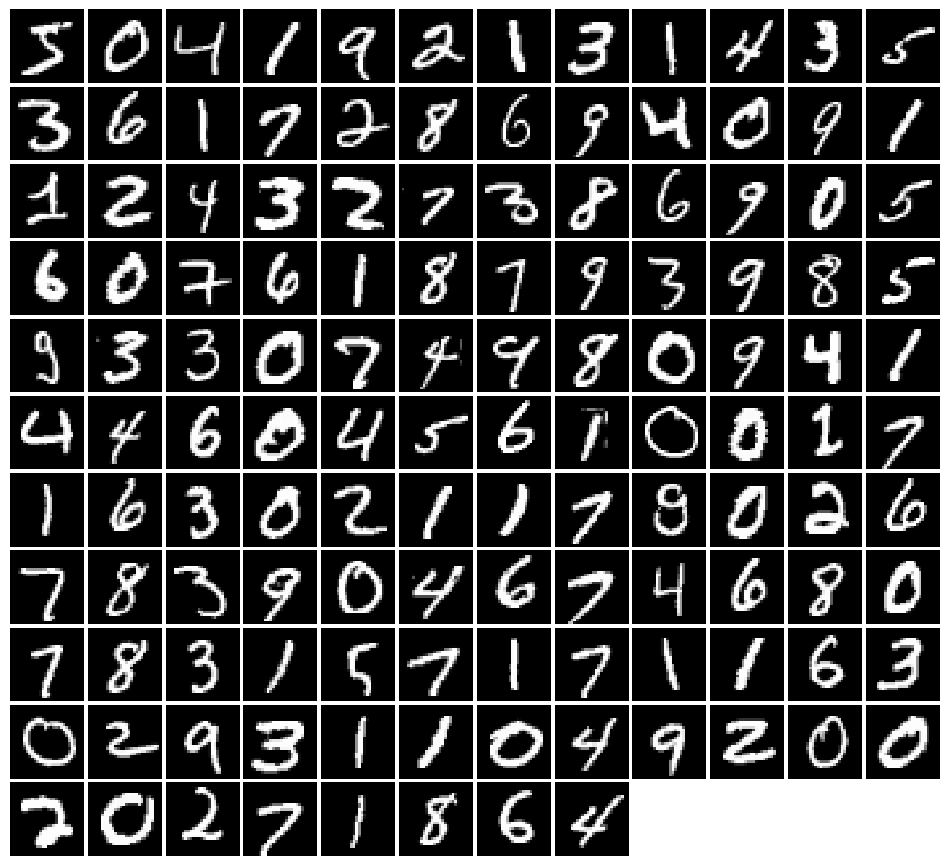

In [3]:
NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

mnist_train = dset.MNIST('./input/datasets/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          sampler=ChunkSampler(NUM_TRAIN, 0))

mnist_val = dset.MNIST('./input/datasets/MNIST_data', train=True, download=True,
                           transform=T.ToTensor())
loader_val = DataLoader(mnist_val, batch_size=batch_size,
                        sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

## Random Noise
生成从-1到1之间（边界不用管）均匀分布的噪声，噪声的 shape 为 `[batch_size, dim]` 。

完成 `daseCV/gan_pytorch.py` 中的 `sample_noise` 函数。

Hint: 使用 `torch.rand` 。

确保生成的噪声的 shape 跟 type 是正确的：

In [4]:
from daseCV.gan_pytorch import sample_noise

def test_sample_noise(): 
    batch_size = 3
    dim = 4
    torch.manual_seed(231)
    z = sample_noise(batch_size, dim)
    np_z = z.cpu().numpy()
    assert np_z.shape == (batch_size, dim)
    assert torch.is_tensor(z)
    assert np.all(np_z >= -1.0) and np.all(np_z <= 1.0)
    assert np.any(np_z < 0.0) and np.any(np_z > 0.0)
    print('All tests passed!')
    
test_sample_noise()

All tests passed!


## Flatten

回想一下以前的 notebooks 中的 Flatten 操作...这次我们还提供了 Unflatten，你可以在实现卷积生成器时使用它。我们还提供了一个权重初始化程序（并已为你导入），它使用 Xavier 初始化而不是 PyTorch 默认值的均匀初始化。

In [5]:
from daseCV.gan_pytorch import Flatten, Unflatten, initialize_weights

## CPU / GPU
默认情况下，所有代码都将在 CPU 上运行。 这次作业不需要 GPU，但 GPU 可以帮助你更快地训练模型。 如果确实要在 GPU 上运行代码，则在以下单元格中更改 `dtype` 变量。 **如果你是 Colab 用户，建议将 Colab runtime 更改为 GPU 模式。**

In [6]:
# dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor ## UNCOMMENT THIS LINE IF YOU'RE ON A GPU!

# Discriminator
我们的第一步就是构建一个判别器。将下面的结构写到 `nn.Sequential` 函数里面去。所有的全连接（FC）层都要包括偏置项。这部分网络结构如下：
 * FC层，输入尺寸：784，输出尺寸：256
 * LeakyReLU，alpha：0.01
 * FC层，输入尺寸：256，输出尺寸：256
 * LeakyReLU，alpha：0.01
 * FC层，输入尺寸：256，输出尺寸：1

回想一下 Leaky ReLU 激活函数的公式 $f(x) = \max(\alpha x, x)$ 其中 $\alpha$ 为固定常数；在该结构中我们将 LeakyReLU 的 $\alpha$ 设置为0.01。

判别器的输出 shape 为  `[batch_size, 1]`，每行的实数值表示该图片被预测为真实图片的得分（score）。

完成 `daseCV/gan_pytorch.py` 中的 `discriminator` 函数

确保判别器中的参数个数是正确的：

In [7]:
from daseCV.gan_pytorch import discriminator

def test_discriminator(true_count=267009):
    model = discriminator()
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in discriminator. Check your achitecture.')
    else:
        print('Correct number of parameters in discriminator.')     

test_discriminator()

Correct number of parameters in discriminator.


# Generator
现在构建生成器网络：
 * FC层，输入尺寸：noise_dim，输出尺寸：1024
 * `ReLU`
 * FC层，尺寸：1024
 * `ReLU`
 * FC层，尺寸：784
 * `TanH` (将图片像素值范围缩放为 `(-1,1)`)

完成 `daseCV/gan_pytorch.py` 中的 `generator()` 函数

测试结果以确保生成器中的参数数量正确：

In [8]:
from daseCV.gan_pytorch import generator

def test_generator(true_count=1858320):
    model = generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_generator()

Correct number of parameters in generator.


# GAN Loss
计算生成器跟判别器的损失。生成器的损失为：
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
判别器的损失为：
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
请注意，这里的公式与先前的公式相比多了个负号，因为在这里我们的目标是*最小化*这些损失。

**HINTS**：你应该使用下面定义的 `bce_loss` 函数来计算二元交叉熵损失。在计算二元交叉熵损失前，需要先对鉴别器输出的真实标签类（标签为1）的 logits（scores）进行 log 运算得到概率。给定 score $s\in\mathbb{R}$ 以及标签 $y\in\{0, 1\}$，二元交叉熵损失为

$$ bce(s, y) = -y * \log(s) - (1 - y) * \log(1 - s) $$

该公式的简单版本可能会出现数值不稳定的情况，因此下面我们为你提供一种数值稳定的方法。[方法解析](http://gameofdimension.com/2017/10/29/numerical-stability/)

你需要根据数据是真还是假去得到标签，根据 logit 的参数确定标签的 shape。请确保使用 `dtype` 参数将标签数据转换为正确的数据类型（比如是CPU还是GPU的数据），例如：

`true_labels = torch.ones(size).type(dtype)`

我们将计算每个 minibatch 的平均损失而不是对 minibatch 的每个期望值 $\log D(G(z))$, $\log D(x)$ 和 $\log \left(1-D(G(z))\right)$ 求和。

完成 `daseCV/gan_pytorch.py` 中的 `bce_loss`, `discriminator_loss`, `generator_loss`

验证你的生成器跟判别器损失。错误应小于1e-7。

In [9]:
from daseCV.gan_pytorch import bce_loss, discriminator_loss, generator_loss

def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
    d_loss = discriminator_loss(torch.Tensor(logits_real).type(dtype),
                                torch.Tensor(logits_fake).type(dtype)).cpu().numpy()
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))

test_discriminator_loss(answers['logits_real'], answers['logits_fake'],
                        answers['d_loss_true'])

Maximum error in d_loss: 3.97058e-09


In [10]:
def test_generator_loss(logits_fake, g_loss_true):
    g_loss = generator_loss(torch.Tensor(logits_fake).type(dtype)).cpu().numpy()
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_generator_loss(answers['logits_fake'], answers['g_loss_true'])

Maximum error in g_loss: 4.4518e-09


# Optimizing our loss
写一个 `optim.Adam` 优化器，针对给定的模型我们设置learning rate=1e-3， beta1=0.5，beta2=0.999。在该notebook 接下来的部分你将会使用这些参数构建你的优化器去优化生成器跟判别器。

完成 `daseCV/gan_pytorch.py` 中的 `get_optimizer` 函数

# Training a GAN!
我们为你提供了主要的训练流程... 不需要修改 `daseCV/gan_pytorch.py` 中的 `run_a_gan` 函数，但是我希望你们去读一下这部分的代码并理解它。

In [11]:
from daseCV.gan_pytorch import get_optimizer, run_a_gan


In [12]:
# Make the discriminator
D = discriminator().type(dtype)

# Make the generator
G = generator().type(dtype)

# Use the function you wrote earlier to get optimizers for the Discriminator and the Generator
D_solver = get_optimizer(D)
G_solver = get_optimizer(G)
# Run it!
images = run_a_gan(D, G, D_solver, G_solver, discriminator_loss, generator_loss, loader_train)

Iter: 0, D: 1.328, G:0.7202
Iter: 250, D: 1.043, G:1.574
Iter: 500, D: 1.22, G:1.262
Iter: 750, D: 1.318, G:0.8528
Iter: 1000, D: 1.245, G:1.097
Iter: 1250, D: 1.327, G:0.8783
Iter: 1500, D: 1.253, G:0.8658
Iter: 1750, D: 1.402, G:0.8642
Iter: 2000, D: 1.2, G:0.9398
Iter: 2250, D: 1.304, G:0.8984
Iter: 2500, D: 1.265, G:0.8064
Iter: 2750, D: 1.277, G:0.8124
Iter: 3000, D: 1.301, G:0.838
Iter: 3250, D: 1.254, G:0.9825
Iter: 3500, D: 1.375, G:0.8204
Iter: 3750, D: 1.306, G:0.8105


运行下面的单元格以显示生成的图像。

Iter: 0


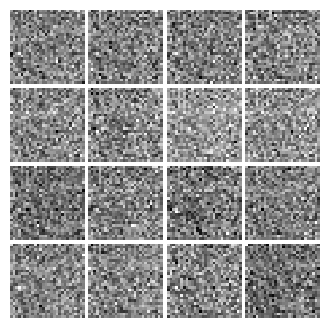


Iter: 250


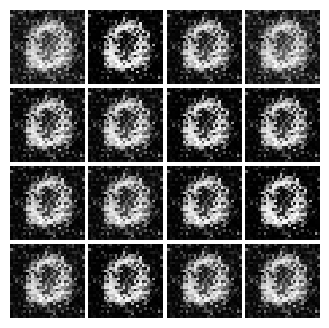


Iter: 500


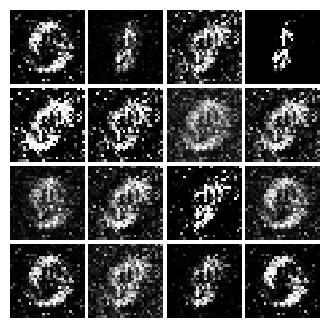


Iter: 750


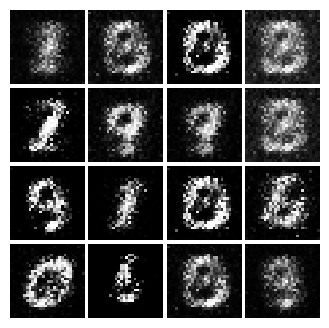


Iter: 1000


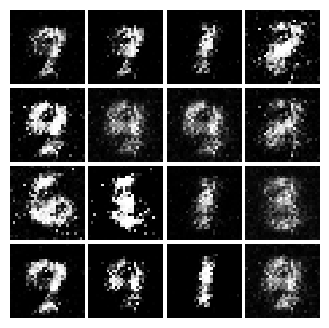


Iter: 1250


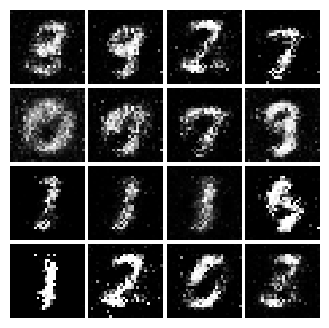


Iter: 1500


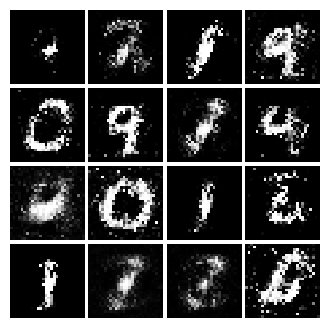


Iter: 1750


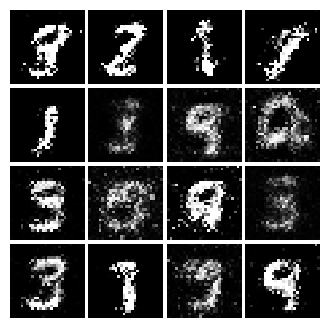


Iter: 2000


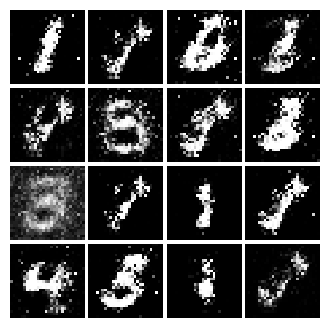


Iter: 2250


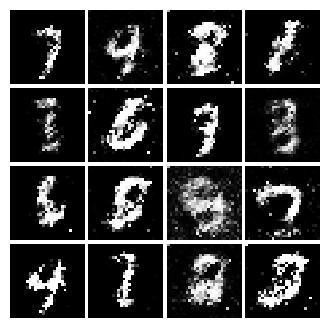


Iter: 2500


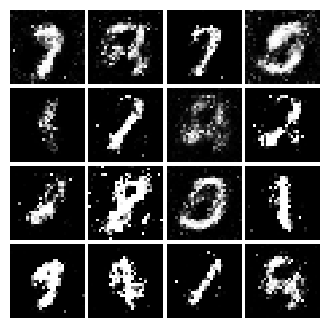


Iter: 2750


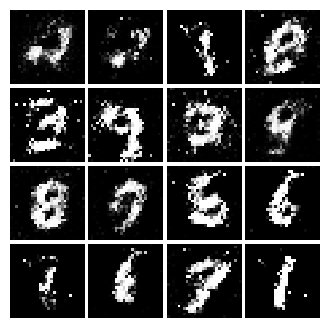


Iter: 3000


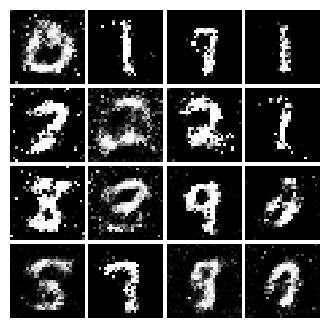


Iter: 3250


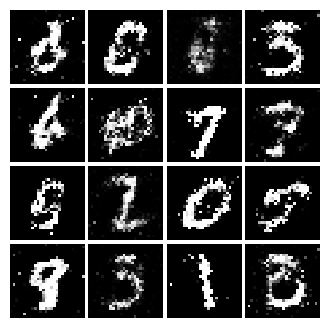


Iter: 3500


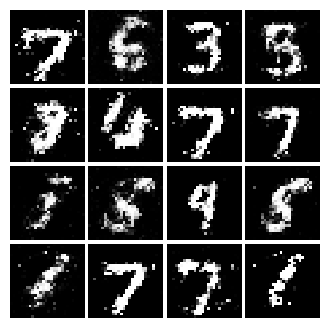


Iter: 3750


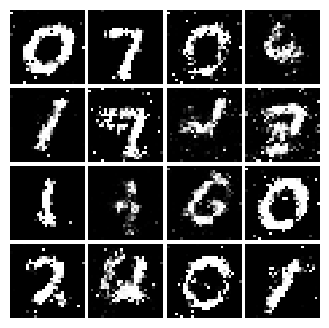

In [13]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

**提交时，请运行下面的单元格。**

Vanilla GAN Fianl image:


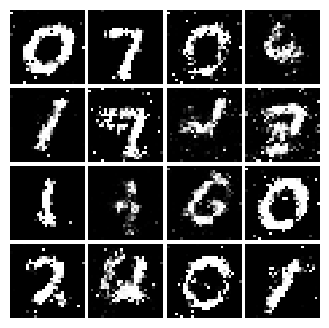

In [14]:
print("Vanilla GAN Fianl image:")
show_images(images[-1])
plt.show()

好吧，这并不难，不是吗？ 在最开始的100次的迭代中，你应该看到黑色背景，接近迭代1000次时可以看到模糊和不错的的形状，当我们迭代超过3000次时，其中大约一半的内容将变得清晰可见。

# Least Squares GAN
现在我们来看一下 [Least Squares GAN](https://arxiv.org/abs/1611.04076)，一种新的更稳定的对原先 GAN 损失函数优化的方法（[中文解析](https://blog.csdn.net/cuihuijun1hao/article/details/83114145)）。这部分我们只要改变原有的损失函数并重新训练模型就好。我们将实现论文中的公式(9)，修改生成器损失为：
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
判别器损失为：
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$

**HINTS**: 计算每个 minibatch 的平均损失而不是对期望值求和。当我们处理 $D(x)$ 和 $D(G(z))$ 的时候直接用判别器的输出 (`scores_real` 和 `scores_fake`)。

在 `daseCV/gan_pytorch.py` 中完成 `ls_discriminator_loss`, `ls_generator_loss` 这两个函数

在用新的损失函数跑 GAN 前，我们先 check 一下：

In [15]:
from daseCV.gan_pytorch import ls_discriminator_loss, ls_generator_loss

def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    score_real = torch.Tensor(score_real).type(dtype)
    score_fake = torch.Tensor(score_fake).type(dtype)
    d_loss = ls_discriminator_loss(score_real, score_fake).cpu().numpy()
    g_loss = ls_generator_loss(score_fake).cpu().numpy()
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],
                answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 1.53171e-08
Maximum error in g_loss: 2.7837e-09


运行以下单元格来训练你的模型！

In [16]:
D_LS = discriminator().type(dtype)
G_LS = generator().type(dtype)

D_LS_solver = get_optimizer(D_LS)
G_LS_solver = get_optimizer(G_LS)

images = run_a_gan(D_LS, G_LS, D_LS_solver, G_LS_solver, ls_discriminator_loss, ls_generator_loss, loader_train)

Iter: 0, D: 0.5689, G:0.51
Iter: 250, D: 0.1487, G:0.2958
Iter: 500, D: 0.1049, G:0.3745
Iter: 750, D: 0.128, G:0.3359
Iter: 1000, D: 0.1822, G:0.245
Iter: 1250, D: 0.1767, G:0.322
Iter: 1500, D: 0.1581, G:0.2521
Iter: 1750, D: 0.2078, G:0.1941
Iter: 2000, D: 0.2077, G:0.417
Iter: 2250, D: 0.2365, G:0.1838
Iter: 2500, D: 0.229, G:0.1851
Iter: 2750, D: 0.2349, G:0.1661
Iter: 3000, D: 0.2128, G:0.1637
Iter: 3250, D: 0.2352, G:0.1756
Iter: 3500, D: 0.2188, G:0.1699
Iter: 3750, D: 0.2383, G:0.1455


运行以下单元格来展示生成的图片。

Iter: 0


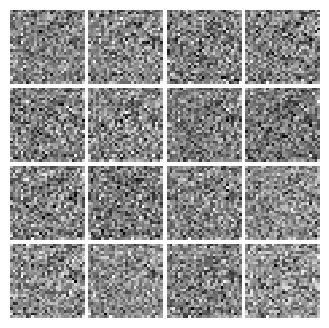


Iter: 250


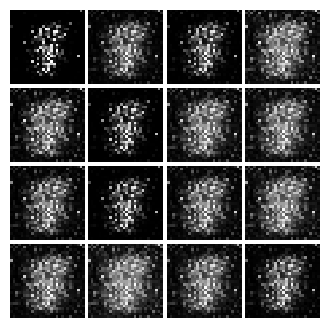


Iter: 500


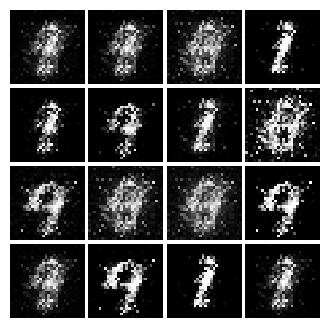


Iter: 750


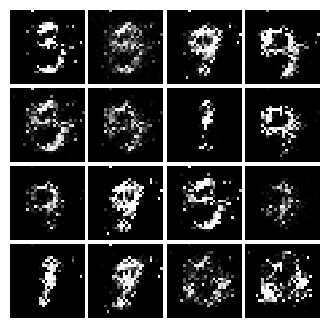


Iter: 1000


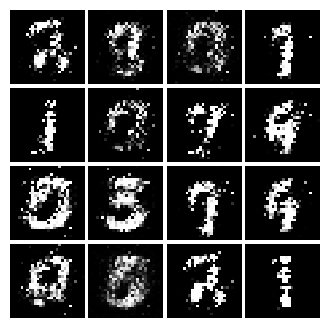


Iter: 1250


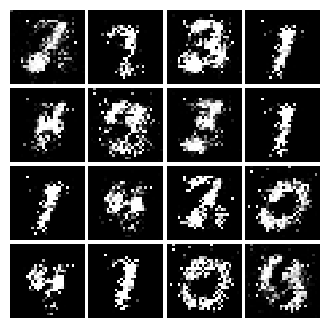


Iter: 1500


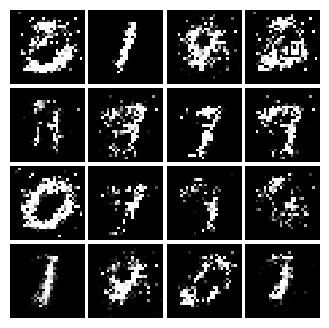


Iter: 1750


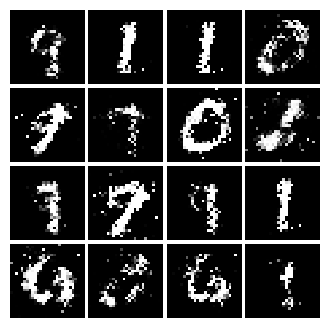


Iter: 2000


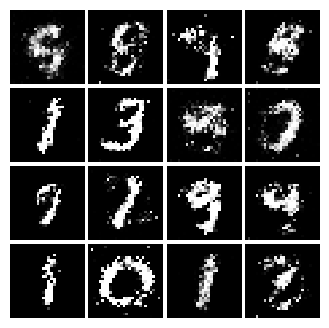


Iter: 2250


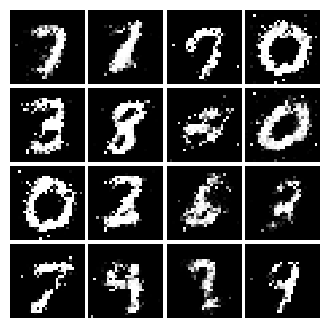


Iter: 2500


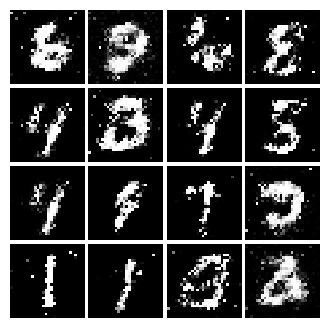


Iter: 2750


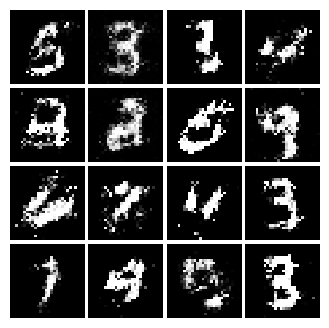


Iter: 3000


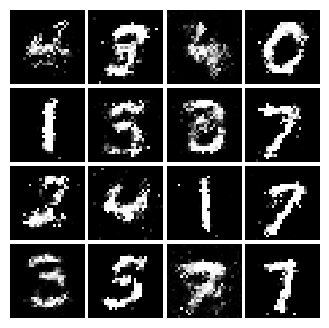


Iter: 3250


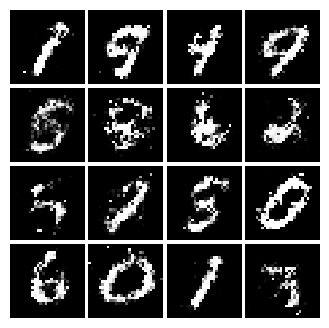


Iter: 3500


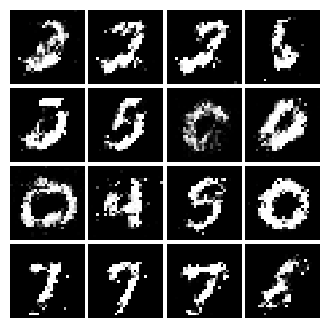


Iter: 3750


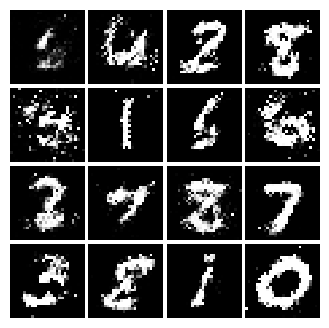

In [17]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

**提交时，请运行下面的单元格。**

LSGAN Fianl image:


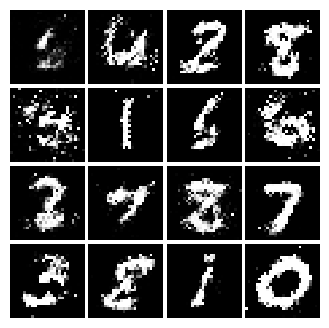

In [18]:
print("LSGAN Fianl image:")
show_images(images[-1])
plt.show()

# Deeply Convolutional GANs
在这个 notebook 的开头部分，我们几乎完全照搬了 Ian Goodfellow 的最初始版本的 GAN 网络。然而这个网络的结构注定了生成的图片不具备空间合理性。它通常无法推理诸如“尖锐的边缘”之类的东西因为它没有卷积层。因此，在这小结，我们会去实现 [DCGAN](https://arxiv.org/abs/1511.06434) 中的一些想法，在实现的过程中我们会使用卷积神经网络。（[DCGAN 中文解释](https://blog.csdn.net/qq_33594380/article/details/84135797)）

#### 判别器
我们受 TensorFlow MNIST 分类教程的启发，该分类器能够在 MNIST 数据集上相当快地达到99％以上的准确率，因此我们打算使用该分类器作为判别器。
* Reshape into image tensor (Use Unflatten!)
* Conv2D: 32 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Conv2D: 64 Filters, 5x5, Stride 1
* Leaky ReLU(alpha=0.01)
* Max Pool 2x2, Stride 2
* Flatten
* Fully Connected with output size 4 x 4 x 64
* Leaky ReLU(alpha=0.01)
* Fully Connected with output size 1

在 `daseCV/gan_pytorch.py` 中完成 `build_dc_classifier` 函数

In [19]:
from daseCV.gan_pytorch import build_dc_classifier

data = next(enumerate(loader_train))[-1][0].type(dtype)
b = build_dc_classifier(batch_size).type(dtype)
out = b(data)
print(out.size())

torch.Size([128, 1])


检查分类器中参数的数量，作为完整性检查：

In [20]:
def test_dc_classifer(true_count=1102721):
    model = build_dc_classifier(batch_size)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_dc_classifer()

Correct number of parameters in generator.


#### 生成器
对于生成器我们直接拷贝 [InfoGAN paper](https://arxiv.org/pdf/1606.03657.pdf) 中的结构 （[InfoGAN paper简单解释](https://zhuanlan.zhihu.com/p/55945164)）。See Appendix C.1 MNIST。查看 [tf.nn.conv2d_transpose](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose) 的文档信息（[torch.nn.ConvTranspose2d中文解释](https://blog.csdn.net/qq_27261889/article/details/86304061)）。对于Batch Normalization，假设我们始终处于 'training' 模式。
* Fully connected with output size 1024
* `ReLU`
* BatchNorm
* Fully connected with output size 7 x 7 x 128 
* ReLU
* BatchNorm
* Reshape into Image Tensor of shape 7, 7, 128
* Conv2D^T (Transpose): 64 filters of 4x4, stride 2, 'same' padding (use `padding=1`)
* `ReLU`
* BatchNorm
* Conv2D^T (Transpose): 1 filter of 4x4, stride 2, 'same' padding (use `padding=1`)
* `TanH`
* Should have a 28x28x1 image, reshape back into 784 vector

从上面的步骤中可以看出 InfoGAN 的特别之处在于它的转置卷积（反卷积）过程。

在 `daseCV/gan_pytorch.py` 中实现 `build_dc_generator` 函数

In [21]:
from daseCV.gan_pytorch import build_dc_generator

test_g_gan = build_dc_generator().type(dtype)
test_g_gan.apply(initialize_weights)

fake_seed = torch.randn(batch_size, NOISE_DIM).type(dtype)
fake_images = test_g_gan.forward(fake_seed)
fake_images.size()

torch.Size([128, 784])

检查生成器中参数的数量，作为完整性检查：

In [22]:
def test_dc_generator(true_count=6580801):
    model = build_dc_generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_dc_generator()

Correct number of parameters in generator.


In [23]:
D_DC = build_dc_classifier(batch_size).type(dtype) 
D_DC.apply(initialize_weights)
G_DC = build_dc_generator().type(dtype)
G_DC.apply(initialize_weights)

D_DC_solver = get_optimizer(D_DC)
G_DC_solver = get_optimizer(G_DC)

images = run_a_gan(D_DC, G_DC, D_DC_solver, G_DC_solver, discriminator_loss, generator_loss, loader_train, num_epochs=5)

Iter: 0, D: 1.403, G:1.434
Iter: 250, D: 1.488, G:0.3538
Iter: 500, D: 1.081, G:1.241
Iter: 750, D: 1.11, G:0.7588
Iter: 1000, D: 1.177, G:0.9995
Iter: 1250, D: 1.26, G:0.9946
Iter: 1500, D: 1.078, G:0.9119
Iter: 1750, D: 1.049, G:1.035


运行以下单元格来展示生成的图片。

Iter: 0


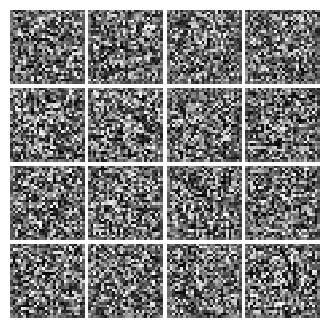


Iter: 250


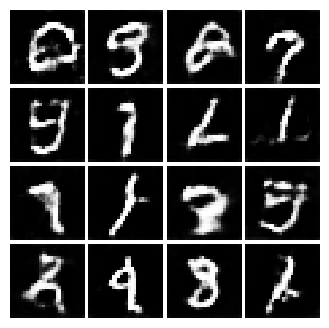


Iter: 500


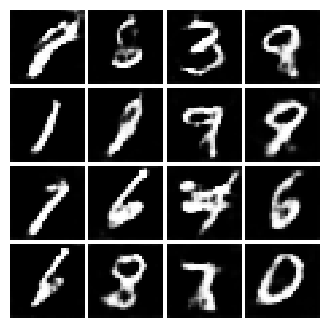


Iter: 750


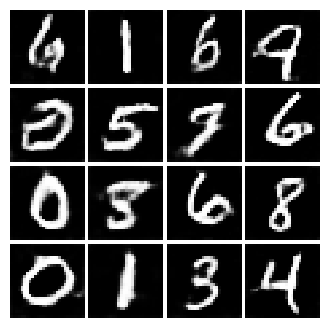


Iter: 1000


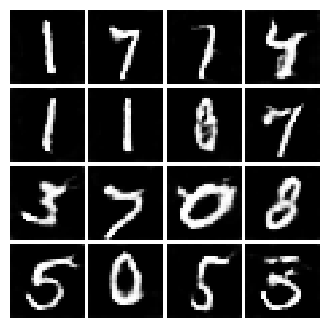


Iter: 1250


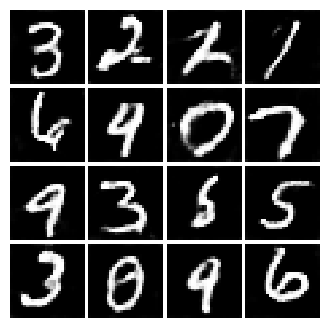


Iter: 1500


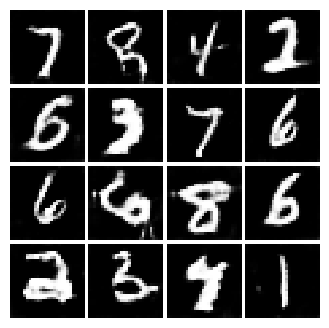


Iter: 1750


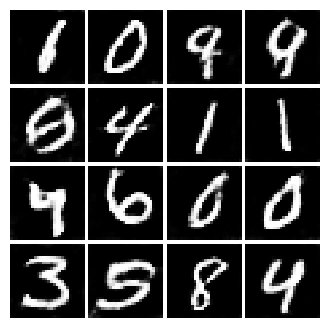

In [24]:
numIter = 0
for img in images:
    print("Iter: {}".format(numIter))
    show_images(img)
    plt.show()
    numIter += 250
    print()

**提交时，请运行下面的单元格。**

DCGAN Fianl image:


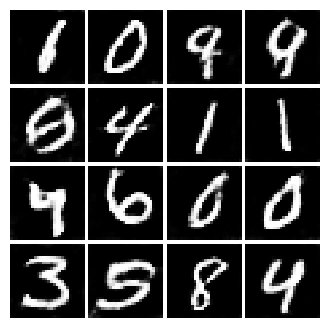

In [25]:
print("DCGAN Fianl image:")
show_images(images[-1])
plt.show()

## INLINE QUESTION 1
我们来看一个例子，看看为什么交替最小化同一目标（例如在GAN中）可能是棘手的事情。

考虑公式$f(x,y)=xy$。$\min_x\max_y f(x,y)$ 会出现什么结果？(Hint: minmax尝试最小化可能的最大值。)

现在我们尝试用6步去优化这个方程，设起始点为 $(1,1)$，step size 为 $1$(先更新 y， 然后用更新后的 y 更新 x)。**在这里 step size=learning_rate，learning_rate * gradient 为步长。**
你会发现用 $x_t,y_t,x_{t+1},y_{t+1}$ 写出中间步骤会有助于分析该问题。

简单解释 $\min_x\max_y f(x,y)$ 的计算结果并在下述表格中记录每一步 $(x_t,y_t)$ 的显式值。

### Your answer:

 
 $y_0$ | $y_1$ | $y_2$ | $y_3$ | $y_4$ | $y_5$ | $y_6$ 
 ----- | ----- | ----- | ----- | ----- | ----- | ----- 
  1   |    2   |    1   |   -1    |    -2   |   -1    |     1  
 $x_0$ | $x_1$ | $x_2$ | $x_3$ | $x_4$ | $x_5$ | $x_6$ 
  1   |    -1   |   -2    |   -1    |    1   |    2   |      1 
   
我们可以看到，由于 $\min_x\max_y f(x,y)$ 的结构，$y$ 的更新会导致 $x$ 的值增大，而 $x$ 的更新又导致 $y$ 的值减小。这种相互影响导致了困难的优化问题。



## INLINE QUESTION 2
使用这种方法，我们能否达到最佳值？ 为什么能或者为什么不能？

使用这种方法，我们不能达到最佳值。原因在于 $\min_x\max_y f(x, y)$ 的优化问题中存在所谓的“鞍点”问题。具体来说，在这个问题中，我们交替地最小化 $x$ 和最大化 $y$。然而，由于目标函数 $f(x, y) = xy$ 的形状，$x$ 和 $y$ 的优化目标是相互矛盾的。具体来说，当我们最小化 $x$ 时，$y$ 的目标是尽可能小，从而最大化 $f(x, y)$；反之亦然。这导致了 $x$ 和 $y$ 之间的竞争，使得优化过程非常困难。

## INLINE QUESTION 3
如果在训练过程中生成器损失减少，而判别器损失从一开始就保持恒定的高值，这是一个好兆头吗？ 为什么或者为什么不？ 给一个定性的答案就好。

这不是一个好兆头。这可能表明生成器在学习中取得了一些进展，但判别器很可能已经收敛到一个较差的状态，无法有效地区分真实和生成的样本。这种情况可能导致生成器生成的样本质量不佳，因为判别器无法提供有效的反馈。